In [1]:
import os
import sys
import json
import time
import pickle
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
# from mpl_toolkits.axisartist.axislines import AxesZero
from scipy import signal, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

In [5]:
plt.rcParams.update({'font.size': 12})

Load CCF for identifying cortical areas

In [6]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [7]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [8]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

In [9]:
area_colors = {
    'MO': 'blue', # [31, 157, 90]
    'ACA': 'deepskyblue', # [64, 166, 102]
    'SS': 'blueviolet', # [24, 128, 100]
    'VIS': 'green', # [8, 133, 140]
    'TH': 'steelblue', # [255, 112, 128]
#     'VIS-TH': 'olivedrab'
}

In [10]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}

#### Functions

In [11]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='resting'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [12]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

## Load subjects from file

In [13]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects_wPROBES.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [14]:
# plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs'
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots'

## Choose example subjects and load experiment

In [15]:
example_mice = {
    'MOs_deep': '569073'
}

In [16]:
ex_sub_dict = {x: {} for x in example_mice.keys()}
for group, mouse in example_mice.items():
    print('{} - {}'.format(group, mouse))
    ex_sub_dict[group][mouse] = multi_sub_dict[group][mouse]
    ex_sub_dict[group][mouse]['exp'] = EEGexp(multi_sub_dict[group][mouse]['data_loc'], preprocess=False, make_stim_csv=False)
    print('')

MOs_deep - 569073
Experiment type: electrical and sensory stimulation



## Gather data for example subjects

In [17]:
chtrials = 'resting' # choose: 'resting', 'running', or 'all'
apply_car = True

celltype = 'RS'
event_window = [-1.0, 1.0]
time_bin = 0.005 # size of time bins (s)
bins = np.arange(event_window[0], event_window[1] + time_bin, time_bin)
timex = bins[:-1] + time_bin/2

current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

In [18]:
for group, group_subs in ex_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
        mdata['data'] = {}
        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        try:
            bad_chs = mdata['bad_chs']
        except KeyError:
            badchstr = exp_meta['EEG bad_channels'].replace(' ','')
            bad_chs = []
            for char in badchstr.split(','):
                if char.isdecimal():
                    bad_chs.append(int(char))
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)
        if len(currents_list) > 1:
            PCI_stim_amp = currents_list[1]
        elif len(currents_list) == 1:
            PCI_stim_amp = currents_list[0]
        else:
            print('No stim current listed in Zap_Zip-log_exp')

        ## Load stim log (includes running speed now) ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
        
        ## Load EEG traces ##
        all_EEG_traces = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces.npy'))
        EEG_event_timestamps = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces_times.npy'))
        eeg_chs = np.arange(0, all_EEG_traces.shape[1])
        GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
        mdata['good_chs'] = GOOD_CHS
        
        ## Load LFP info and traces ##
        with open(os.path.join(evoked_data_folder, 'evokedLFPinfo.json')) as info_file:
            LFPinfo = json.load(info_file)
        LFP_event_ts = np.load(os.path.join(evoked_data_folder, 'evokedLFPtimestamps.npy'))
        
        ## Load unit data ##
        unit_info = pd.read_csv(os.path.join(evoked_data_folder, 'units_info_' + group + '.csv'))
        with open(os.path.join(evoked_data_folder, 'units_evoked_activity_' + group + '.pkl'), 'rb') as unit_file:
            unit_activity = pickle.load(unit_file)
            
        ## Load regional stuff ##
        reg_allLFPtraces = {}
        reg_unit_info = {}
        for region in areas_of_interest.keys():
            if region in LFPinfo.keys():
                reg_allLFPtraces[region] = np.load(os.path.join(evoked_data_folder, region + '_evokedLFPtraces.npy'))
            
            regdf = unit_info[(unit_info['cell_type'] == celltype) & (unit_info['parent'] == region)]
            if len(regdf) > 0:
                reg_unit_info[region] = regdf.sort_values(by='depth')
        
        EEG_traces = {}
        LFP_traces = {}
        unit_traces = {}
        for leveli, parami in zip(current_levels, currents_list):
            EEG_traces[leveli] = {}
            LFP_traces[leveli] = {}
            unit_traces[leveli] = {}

            for statei in test_states:
                LFP_traces[leveli][statei] = {}
                unit_traces[leveli][statei] = {}
                
                sweeps = mdata['states'][statei]
                if sweeps:
                    state_event_inds = []
                    for sweepi in sweeps:
                        eventinds = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=chtrials)
                        if len(eventinds) == 0:
                            continue
                        state_event_inds.append(eventinds)
                    state_event_inds = np.concatenate(state_event_inds)

                    ## Get evoked EEG traces ##
                    event_traces = all_EEG_traces[:, :, state_event_inds]
                    ## Apply common avg ##
                    if apply_car:
                        event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                    EEG_traces[leveli][statei] = [EEG_event_timestamps, event_traces]
                    ## Calculate PCI ##
#                     print('   ...calculating PCI...')
#                     full_PCI_output = calc_PCIst(
#                         EEG_traces[leveli][statei][1][:, GOOD_CHS].T,
#                         EEG_traces[leveli][statei][0],
#                         full_return=True,
#                         **PCI_params
#                     )
#                     PCI[leveli][statei]['PCI'] = full_PCI_output['PCI']
#                     PCI[leveli][statei]['n_dims'] = full_PCI_output['n_dims']

                    for region in areas_of_interest.keys():
                        ## Get evoked LFP traces ##
                        if region in reg_allLFPtraces.keys():
                            LFP_traces[leveli][statei][region] = [
                                LFP_event_ts, reg_allLFPtraces[region][:, :, state_event_inds]]
                            
                        ## Get unit z-score ##
                        if region in reg_unit_info.keys():
                            all_firing_rates = np.empty((len(reg_unit_info[region]), len(bins)-1)) * np.nan
                            for uni, uniti in enumerate(reg_unit_info[region]['unit_id'].values):
                                spike_counts, edges = np.histogram(
                                    np.concatenate(unit_activity[uniti][leveli][statei]['event_spikes']), bins)
                                all_firing_rates[uni, :] = spike_counts / (
                                    time_bin * unit_activity[uniti][leveli][statei]['trial_count'])
                            all_unit_Z, non_nan_inds = get_zscore_fr(all_firing_rates, bins)
                            unit_traces[leveli][statei][region] = [timex, all_unit_Z]
        

        mdata['data']['EEG'] = EEG_traces
        mdata['data']['LFP'] = LFP_traces
        mdata['data']['unit_zscores'] = unit_traces
        
        ### After each subject, delete common variables ###
        del stim_log
        del all_EEG_traces, EEG_event_timestamps
        del reg_allLFPtraces, LFP_event_ts, LFPinfo
        del unit_activity, unit_info, reg_unit_info
        del EEG_traces, LFP_traces, unit_traces
        print('')

MOs_superficial

 571619

MOs_deep

 571619



### Plot figure 4: two subjects examples with EEG and unit zscores for awake and anesthetized

<IPython.core.display.Javascript object>


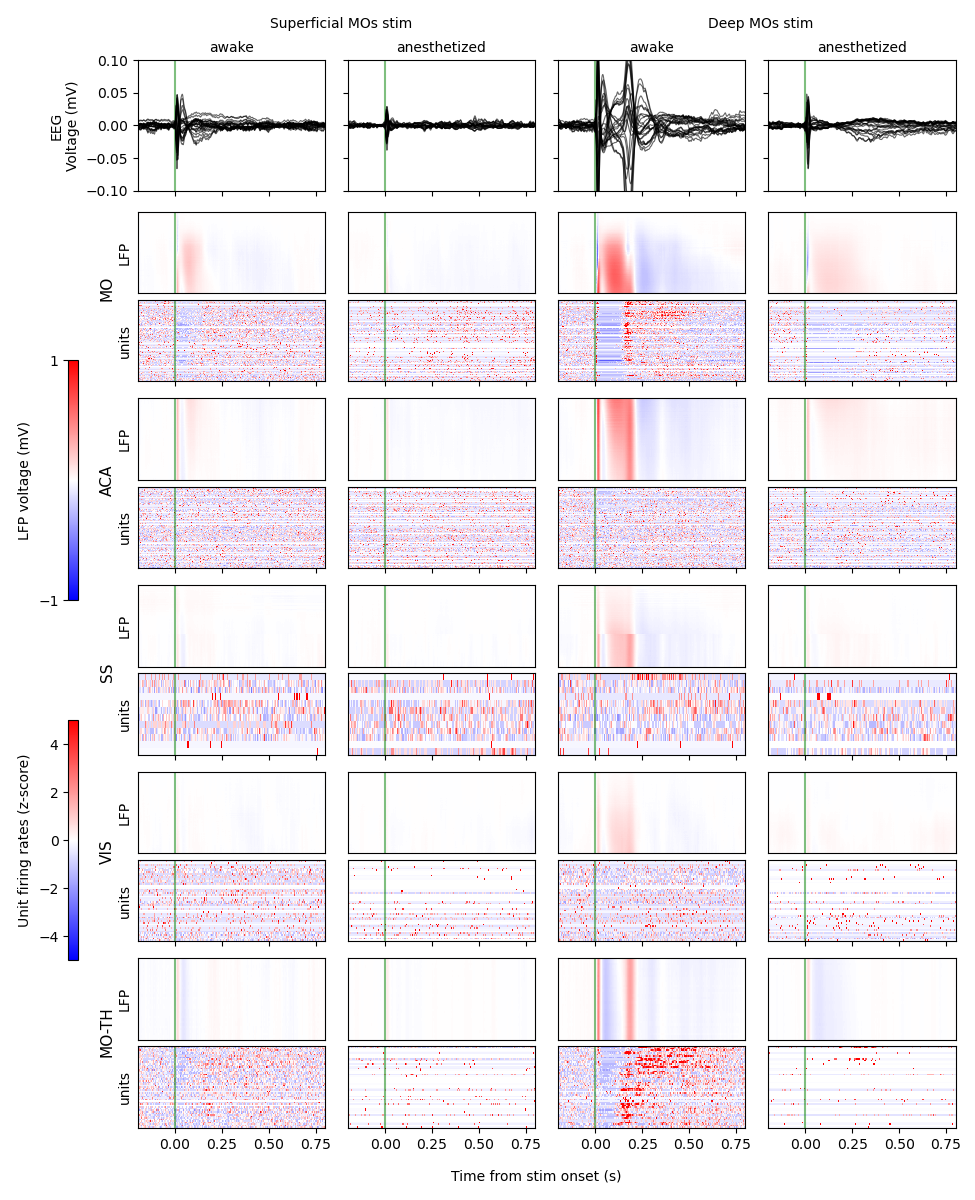

In [85]:
plwin = [-0.2, 0.8]
eeg_ylim = [-0.1, 0.1]
vlevel = 1
Zlim = 5
plevel = 'medium'

fig = plt.figure(figsize=(9.75, 12))
gs = fig.add_gridspec(
    ncols=2, nrows=2, height_ratios=[1, 7], width_ratios=[0.01, 1], left=0.12, right=0.98, top=0.95, bottom=0.06,
    wspace=0.03, hspace=0.04)
EEGaxs = gs[0,1].subgridspec(
    ncols=(len(test_states) * len(example_mice)), nrows=1, wspace=0.12).subplots(sharex=True, sharey=True)
NPXgs = gs[1,1].subgridspec(
    ncols=(len(test_states) * len(example_mice)), nrows=len(areas_of_interest), hspace=0.1, wspace=0.12)

for ii, (group, mouse) in enumerate(example_mice.items()):
    EEG_traces = ex_sub_dict[group][mouse]['data']['EEG'][plevel]
    LFP_traces = ex_sub_dict[group][mouse]['data']['LFP'][plevel]
    unitZ = ex_sub_dict[group][mouse]['data']['unit_zscores'][plevel]
    GOOD_CHS = ex_sub_dict[group][mouse]['good_chs']
    
    for jj, statei in enumerate(test_states):
        coli = 2 * ii + jj
        ## Plot EEG traces ##
        EEGaxs[coli].axvline(0, color='g', alpha=0.5)
        EEGaxs[coli].plot(
            EEG_traces[statei][0], np.mean(EEG_traces[statei][1][:, GOOD_CHS, :], axis=2) / 1E3, 'k', linewidth=0.8, alpha=0.6)
        EEGaxs[coli].set_xlim(plwin)
        EEGaxs[coli].set_xticklabels([])
        EEGaxs[coli].set_ylim(eeg_ylim)
        EEGaxs[coli].set_title(statei, fontsize=10)
        if coli == 0:
            EEGaxs[coli].set_ylabel('EEG\nVoltage (mV)')
            
        ## Plot unit z-score activity ##
        for kk, region in enumerate(areas_of_interest.keys()):
            if region not in unitZ[statei].keys():
                continue
            NPXaxs = NPXgs[kk,coli].subgridspec(nrows=2, ncols=1, hspace=0.08).subplots()
            ## LFP ##
            imlfp = NPXaxs[0].imshow(
                np.mean(LFP_traces[statei][region][1], axis=2).T / 1E3, cmap='bwr',
                interpolation='none', aspect='auto', origin='upper', vmin=-vlevel, vmax=vlevel,
                extent=[LFP_traces[statei][region][0][0], LFP_traces[statei][region][0][-1],
                        LFP_traces[statei][region][1].shape[1], 0]
            )
            NPXaxs[0].set_xlim(plwin)
            NPXaxs[0].axvline(0, color='g', alpha=0.5)
            NPXaxs[0].set_xticks([])
            NPXaxs[0].set_xticklabels([])
            NPXaxs[0].set_yticks([])
            ## Z-scores ##
            imunit = NPXaxs[1].imshow(
                unitZ[statei][region][1], cmap='bwr',
                interpolation='none', aspect='auto', origin='upper', vmin=-Zlim, vmax=Zlim,
                extent=[unitZ[statei][region][0][0], unitZ[statei][region][0][-1], 0, unitZ[statei][region][1].shape[0]],
            )
            NPXaxs[1].set_xlim(plwin)
            NPXaxs[1].axvline(0, color='g', alpha=0.5)
            if kk < len(areas_of_interest)-1:
                NPXaxs[1].set_xticklabels([])
            NPXaxs[1].set_yticks([])
            if coli == 0:
                NPXaxs[0].set_ylabel('LFP')
                NPXaxs[1].set_ylabel('units')

fig.text(0.11, 0.76, 'MO', rotation='vertical', va='center', ha='center', fontsize=11)
fig.text(0.11, 0.6, 'ACA', rotation='vertical', va='center', ha='center', fontsize=11)
fig.text(0.11, 0.44, 'SS', rotation='vertical', va='center', ha='center', fontsize=11)
fig.text(0.11, 0.29, 'VIS', rotation='vertical', va='center', ha='center', fontsize=11)
fig.text(0.11, 0.14, 'MO-TH', rotation='vertical', va='center', ha='center', fontsize=11)
                
fig.text(0.55, 0.02, 'Time from stim onset (s)', va='center', ha='center', fontsize=10)
# fig.text(0.03, 0.4, 'Unit firing rates (z-score)', rotation='vertical', va='center', ha='center', fontsize=10)

fig.text(0.35, 0.98, 'Superficial MOs stim', va='center', ha='center', fontsize=10)
fig.text(0.78, 0.98, 'Deep MOs stim', va='center', ha='center', fontsize=10)

## Add the colorbar ##
cbgs = gs[1,0].subgridspec(nrows=2, ncols=1, hspace=0.2)

lcbax = plt.subplot(cbgs[0], position=[0.07, 0.5, 0.01, 0.2])
lcb = Colorbar(ax=lcbax, mappable=imlfp, orientation='vertical', ticklocation='left', ticks=[-1,1])
lcb.set_label('LFP voltage (mV)')

ucbax = plt.subplot(cbgs[1], position=[0.07, 0.2, 0.01, 0.2])
ucb = Colorbar(ax=ucbax, mappable=imunit, orientation='vertical', ticklocation='left')
ucb.set_label('Unit firing rates (z-score)')

## Save ##
figname = 'evoked_EEG_LFP_unitZ_rest-iso.png'
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

### Plot figure 4: two subjects examples with EEG and unit zscores for AWAKE only

<IPython.core.display.Javascript object>


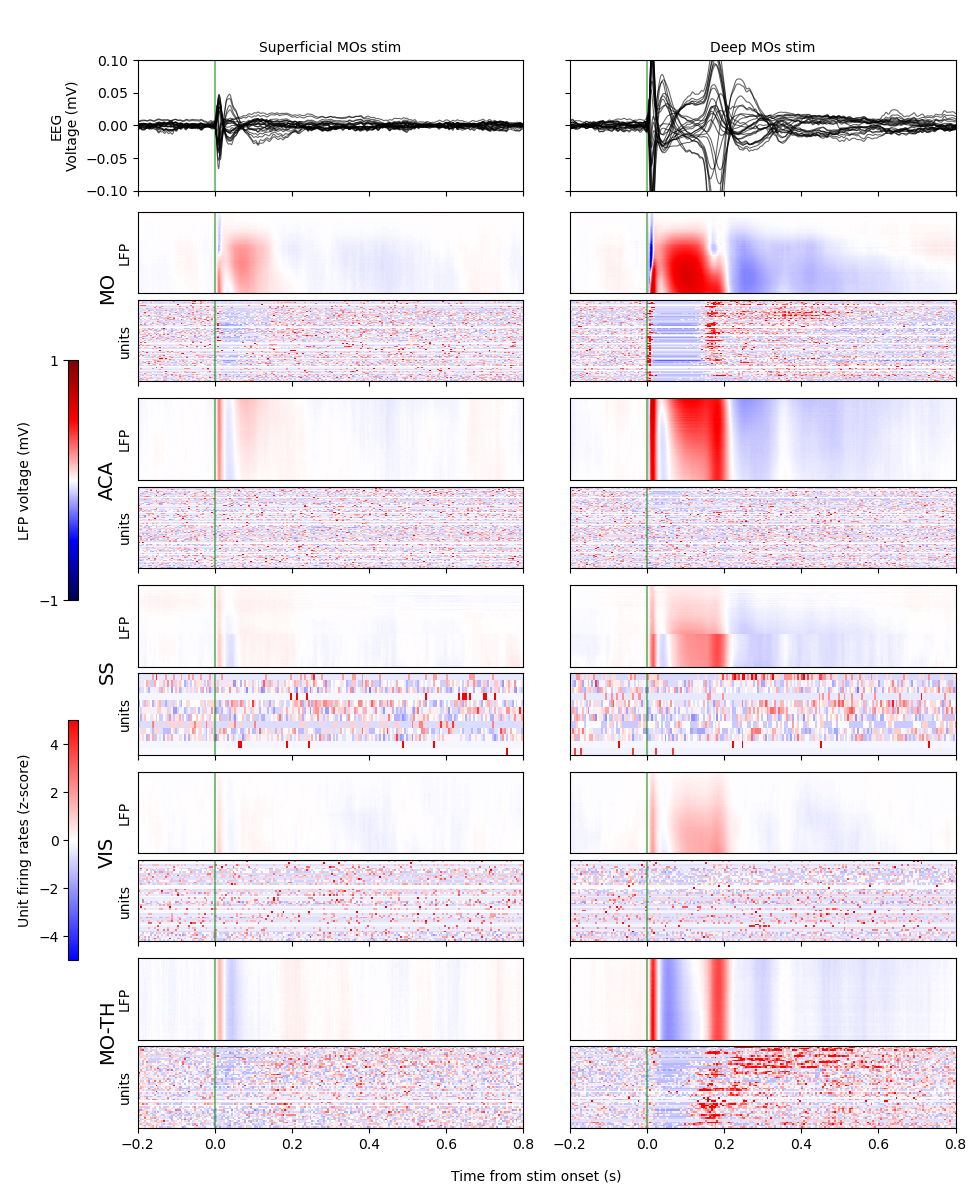

In [24]:
plwin = [-0.2, 0.8]
eeg_ylim = [-0.1, 0.1]
vlevel = 1
Zlim = 5
plevel = 'medium'

fig = plt.figure(figsize=(9.75, 12))
gs = fig.add_gridspec(
    ncols=2, nrows=2, height_ratios=[1, 7], width_ratios=[0.01, 1], left=0.12, right=0.98, top=0.95, bottom=0.06,
    wspace=0.03, hspace=0.04)
EEGaxs = gs[0,1].subgridspec(
    ncols=len(example_mice), nrows=1, wspace=0.12).subplots(sharex=True, sharey=True)
NPXgs = gs[1,1].subgridspec(
    ncols=len(example_mice), nrows=len(areas_of_interest), hspace=0.1, wspace=0.12)

for ii, (group, mouse) in enumerate(example_mice.items()):
    EEG_traces = ex_sub_dict[group][mouse]['data']['EEG'][plevel]
    LFP_traces = ex_sub_dict[group][mouse]['data']['LFP'][plevel]
    unitZ = ex_sub_dict[group][mouse]['data']['unit_zscores'][plevel]
    GOOD_CHS = ex_sub_dict[group][mouse]['good_chs']
    
    statei = 'awake'
    coli = ii
    ## Plot EEG traces ##
    EEGaxs[coli].axvline(0, color='g', alpha=0.5)
    EEGaxs[coli].plot(
        EEG_traces[statei][0], np.mean(EEG_traces[statei][1][:, GOOD_CHS, :], axis=2) / 1E3, 'k', linewidth=0.8, alpha=0.6)
    EEGaxs[coli].set_xlim(plwin)
    EEGaxs[coli].set_xticklabels([])
    EEGaxs[coli].set_ylim(eeg_ylim)
#     EEGaxs[coli].set_title(statei, fontsize=10)
    if coli == 0:
        EEGaxs[coli].set_ylabel('EEG\nVoltage (mV)')

    ## Plot unit z-score activity ##
    for kk, region in enumerate(areas_of_interest.keys()):
        if region not in unitZ[statei].keys():
            continue
        NPXaxs = NPXgs[kk,coli].subgridspec(nrows=2, ncols=1, hspace=0.08).subplots()
        ## LFP ##
        imlfp = NPXaxs[0].imshow(
            np.mean(LFP_traces[statei][region][1], axis=2).T / 1E3, cmap='seismic', #'bwr'
            interpolation='none', aspect='auto', origin='upper', vmin=-vlevel, vmax=vlevel,
            extent=[LFP_traces[statei][region][0][0], LFP_traces[statei][region][0][-1],
                    LFP_traces[statei][region][1].shape[1], 0]
        )
        NPXaxs[0].set_xlim(plwin)
        NPXaxs[0].axvline(0, color='g', alpha=0.5)
        NPXaxs[0].set_xticks([])
        NPXaxs[0].set_xticklabels([])
        NPXaxs[0].set_yticks([])
        ## Z-scores ##
        imunit = NPXaxs[1].imshow(
            unitZ[statei][region][1], cmap='bwr',
            interpolation='none', aspect='auto', origin='upper', vmin=-Zlim, vmax=Zlim,
            extent=[unitZ[statei][region][0][0], unitZ[statei][region][0][-1], 0, unitZ[statei][region][1].shape[0]],
        )
        NPXaxs[1].set_xlim(plwin)
        NPXaxs[1].axvline(0, color='g', alpha=0.5)
        if kk < len(areas_of_interest)-1:
            NPXaxs[1].set_xticklabels([])
        NPXaxs[1].set_yticks([])
        if coli == 0:
            NPXaxs[0].set_ylabel('LFP')
            NPXaxs[1].set_ylabel('units')

fig.text(0.11, 0.76, 'MO', rotation='vertical', va='center', ha='center', fontsize=14)
fig.text(0.11, 0.6, 'ACA', rotation='vertical', va='center', ha='center', fontsize=14)
fig.text(0.11, 0.44, 'SS', rotation='vertical', va='center', ha='center', fontsize=14)
fig.text(0.11, 0.29, 'VIS', rotation='vertical', va='center', ha='center', fontsize=14)
fig.text(0.11, 0.14, 'MO-TH', rotation='vertical', va='center', ha='center', fontsize=14)
                
fig.text(0.55, 0.02, 'Time from stim onset (s)', va='center', ha='center', fontsize=10)
# fig.text(0.03, 0.4, 'Unit firing rates (z-score)', rotation='vertical', va='center', ha='center', fontsize=10)

# fig.text(0.35, 0.98, 'Superficial MOs stim', va='center', ha='center', fontsize=10)
# fig.text(0.78, 0.98, 'Deep MOs stim', va='center', ha='center', fontsize=10)
EEGaxs[0].set_title('Superficial MOs stim')
EEGaxs[1].set_title('Deep MOs stim')

## Add the colorbar ##
cbgs = gs[1,0].subgridspec(nrows=2, ncols=1, hspace=0.2)

lcbax = plt.subplot(cbgs[0], position=[0.07, 0.5, 0.01, 0.2])
lcb = Colorbar(ax=lcbax, mappable=imlfp, orientation='vertical', ticklocation='left', ticks=[-1,1])
lcb.set_label('LFP voltage (mV)')

ucbax = plt.subplot(cbgs[1], position=[0.07, 0.2, 0.01, 0.2])
ucb = Colorbar(ax=ucbax, mappable=imunit, orientation='vertical', ticklocation='left')
ucb.set_label('Unit firing rates (z-score)')

## Save ##
figname = 'evoked_EEG_LFP_unitZ_AWAKEonly.png'
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

### Original plot with EEG and units only